# Introduction

Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts. This is usually used on social media posts and customer reviews in order to automatically understand if some users are positive or negative and why. The goal of this study is to show how sentiment analysis can be performed using python. Here are some of the main libraries we will use:

- NLTK: the most famous python module for NLP techniques
- Gensim: a topic-modelling and vector space modelling toolkit
- Scikit-learn: the most used python machine learning library

We will use here some hotel reviews data. Each observation consists in one customer review for one hotel. Each customer review is composed of a textual feedback of the customer's experience at the hotel and an overall rating. The data can be found here:
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

For each textual review, we want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 2.5/10 to 10/10. In order to simplify the problem we will split those into two categories:
- bad reviews have overall ratings < 5
- good reviews have overall ratings >= 5

The challenge here is to be able to predict this information using only the raw textual data from the review.
Let's get it started!


# Load data

We first start by loading the raw data. Each textual reviews is splitted into a positive part and a negative part. We group them together in order to start with only raw text data and no other information.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9470 sha256=650616710720430f72912bc8cc57ff94e1dcf541e44eaac27e0407d5e6f02a83
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320515 sha256=ac0055fbb97d501243933a6e1c80e9beca0ba0d3225f083e4f3c4f66f1bcfae1
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

In [4]:
import pandas as pd
import numpy as np

from keras import layers
from keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer, one_hot
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Embedding, Conv1D,Conv2D,MaxPool2D, GlobalMaxPooling1D, Dense,Reshape, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
#from keras.layers.merge import concatenate
from keras.layers import concatenate

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#from sklearn.externals import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history


In [5]:
# read data
reviews_df = pd.read_csv("drive/My Drive/Hotel Review/Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


# Sample data

In [6]:
# 统计is_bad_review的唯一值计数
is_bad_review_counts = reviews_df["is_bad_review"].value_counts()

# 获取is_bad_review为0的数据
is_bad_review_0_data = reviews_df[reviews_df["is_bad_review"] == 0]

# 随机抽取is_bad_review为0的数据
is_bad_review_0_data_sample = is_bad_review_0_data.sample(frac=0.1, replace=False, random_state=42)

# 合并is_bad_review为1的数据和随机抽取的is_bad_review为0的数据
reviews_df_new = pd.concat([reviews_df[reviews_df["is_bad_review"] == 1], is_bad_review_0_data_sample])

new_data = {'review': 'I had a wonderful stay at this hotel because of its clean and comfortable room! The staff was friendly . I would definitely recommend it to others.', 'is_bad_review': 0}
reviews_df_new.loc[len(reviews_df_new)] = new_data

new_data = {'review': 'To be honest, the only advantage of this hotel is its price ! When i waked up in the morning and went down, the breakfast were cold already ! Its location is bad too which took me one hour to the city bank', 'is_bad_review': 1}
reviews_df_new.loc[len(reviews_df_new)] = new_data

# 重置索引
reviews_df_new = reviews_df_new.reset_index(drop=True)

# 输出新的数据
reviews_df_new.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,My room was dirty and I was afraid to walk ba...,1
2,Cleaner did not change our sheet and duvet ev...,1
3,The floor in my room was filfy dirty Very bas...,1
4,Our room was an overrated disaster room 231 d...,1


# Clean data

In [7]:
# remove 'No Negative' or 'No Positive' from text
reviews_df_new["review"] = reviews_df_new["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

<Figure size 640x480 with 0 Axes>

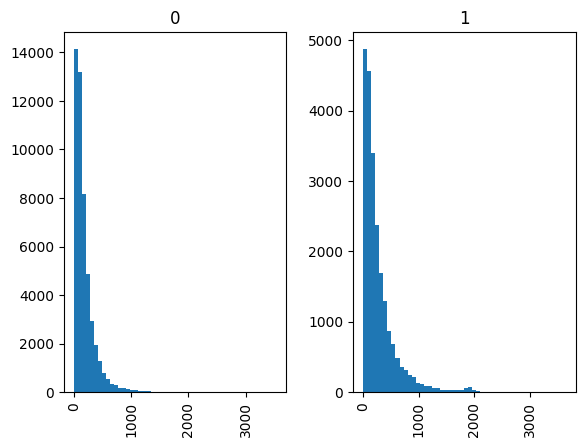

<Figure size 640x480 with 0 Axes>

In [8]:
y=reviews_df_new['is_bad_review'].values
X=reviews_df_new['review'].values

##check the length to determine the document length for DNN

length=reviews_df_new['review'].apply(len)
reviews_df_new=reviews_df_new.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
reviews_df_new.hist(column='Length',by='is_bad_review',bins=50)

plt.figure()

# Data Preprocessing 

In [9]:
# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="drive/My Drive/NLP/TPML_Day2/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)  

vocabubary size: 29647
max length text: 689
0.7277970789624583


# Create class weight dict for unbanlanced dataset

In [10]:
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(14326, 2)

# Build the model

In [11]:
model_dp = Sequential()
model_dp.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_dp.add(Conv1D(512, 3, activation='relu'))
model_dp.add(Dropout(0.3))
model_dp.add(Conv1D(256, 3, activation='relu'))
model_dp.add(GlobalMaxPooling1D())
model_dp.add(Dense(128, activation='relu'))
model_dp.add(Dense(64, activation='relu'))
#dropout layer
model_dp.add(Dropout(0.2))
model_dp.add(Dense(2, activation='softmax'))
model_dp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_dp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 689, 100)          2964700   
                                                                 
 conv1d (Conv1D)             (None, 687, 512)          154112    
                                                                 
 dropout (Dropout)           (None, 687, 512)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 685, 256)          393472    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

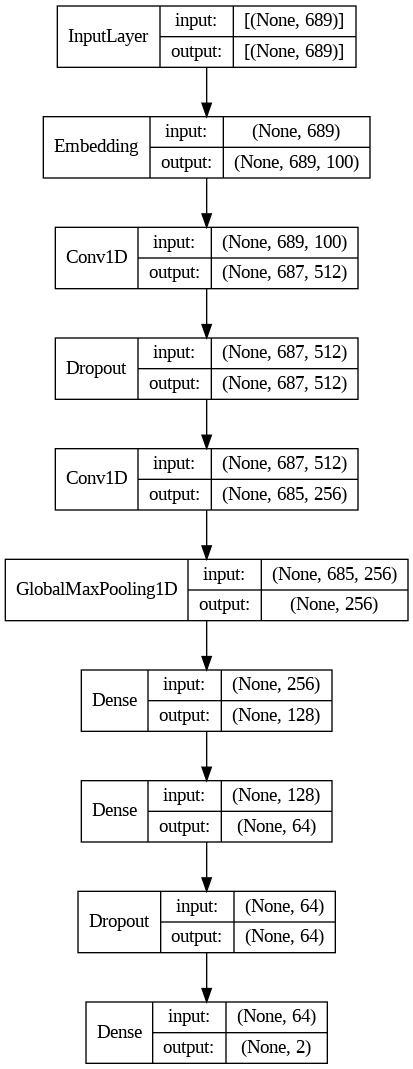

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model_dp, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

# Train the model

Epoch 1/5
448/448 [==============================] - 61s 110ms/step - loss: 0.3995 - accuracy: 0.8127 - val_loss: 0.3238 - val_accuracy: 0.8568
Epoch 2/5
448/448 [==============================] - 50s 112ms/step - loss: 0.3340 - accuracy: 0.8525 - val_loss: 0.3253 - val_accuracy: 0.8547
Epoch 3/5
448/448 [==============================] - 51s 113ms/step - loss: 0.3126 - accuracy: 0.8631 - val_loss: 0.3426 - val_accuracy: 0.8475
Epoch 4/5
448/448 [==============================] - 50s 113ms/step - loss: 0.2930 - accuracy: 0.8712 - val_loss: 0.3490 - val_accuracy: 0.8362
Epoch 5/5
1791/1791 [==============================] - 22s 12ms/step - loss: 0.2253 - accuracy: 0.9147
Training Accuracy: 0.9147
Testing Accuracy:  0.8716


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

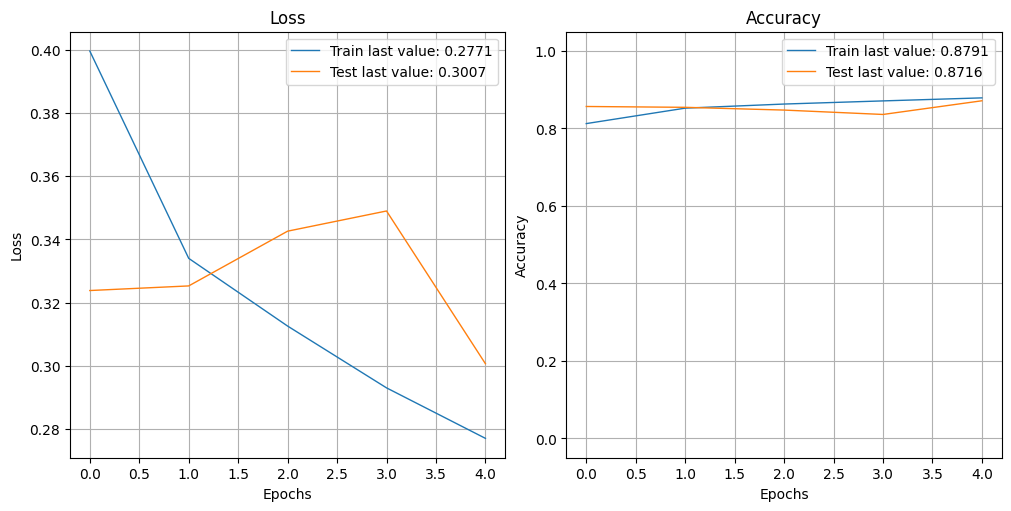

In [13]:
hist = model_dp.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=128).history

loss, accuracy = model_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

# Validation

In [24]:
def predict_review(text):
    tokenizer.fit_on_texts(text)
    text_sequence = tokenizer.texts_to_sequences([text])
    X_input = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    prediction = model_dp.predict(X_input)
    label = 1 if prediction[0][1] > 0.5 else 0
    print("The text is classified as:", label)

test_text = "Unfortunately, my recent stay at a hotel was quite disappointing. The room was dirty and poorly maintained, with stains on the carpet and walls. The bed was uncomfortable and the pillows were flat and lumpy. The staff was unhelpful and seemed uninterested in addressing my concerns. Additionally, the hotel's location was not as advertised, as it was far from the attractions I wanted to visit."
predict_review(test_text)

1/1 [==============================] - 0s 82ms/step
The text is classified as: 1


# Save Model

In [27]:
import pickle
# save model
model_dp.save('model.h5')

# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)